# Saliency analysis for explaining model prediction
## Installation:
For running this notebook, the following additional packages are required:

pythreejs (https://pythreejs.readthedocs.io/en/stable/)

ipywebrtc==0.5.0

ipywidgets==7.5.1  

Installation with pip should work with a recent jupyter version. Reboot the jupyter notebook afterwards.



## Important: Cells must be executed one at time (rather than with Cell -> Run All)




In [1]:
from utilities import wrappers,dataset_utils
from utilities.paths import model_folder,MSA_folder
from preprocessing import pipelines,PDBio,PDB_processing,protein_chemistry,sequence_utils
import tensorflow as tf
import keras.backend as K
import numpy as np
from visualizations import show_3d_filters,show_3d_neighborhoods,weight_logo_3d,ngl
import predict_features
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def flatten_list(nested_list):
    out = []
    for list_ in nested_list:
        out+= list_
    return np.array(out)

def get_gradient(model, input, residue_index, layer = 'SCAN_filter_activity_atom'):
    gradient0 = K.gradients(
        model.model.get_layer('attention_layer').output[0][:, residue_index, 0],
        model.model.get_layer(layer).output
    )

    gradient1 = K.gradients(
        model.model.get_layer('attention_layer').output[0][:, residue_index, 1],
        model.model.get_layer(layer).output
    )
    gradient = gradient0 + gradient1
    activation = model.model.get_layer(layer).output

    sess = K.get_session()
    output = sess.run(gradient +[activation], feed_dict=dict(
        [(input_tensor,input_value[np.newaxis])  for input_tensor,input_value in zip(model.model.inputs, input) ]
    )
    )
    test_gradient = output[1][0] - output[0][0]
    test_activation = output[-1][0]
    return test_gradient,test_activation


def get_saliency(model, inputs, 
                 residue_index, 
                 filter_specificities,sequence,atomids,layer='SCAN_filter_activity_atom'):
    
    gradient,activation = get_gradient(model, inputs, residue_index, 
                                       layer = layer
                                     )
    
    
    natoms = len(flatten_list(atomids))
    nresidues = len(sequence)
    print(natoms,nresidues)
    
    if layer == 'SCAN_filter_activity_atom':
        baseline_entries = filter_specificities['atom_activity']['conditional_median2']
        baseline_activation = np.concatenate([baseline_entries[protein_chemistry.list_aa.index(aa),atomid] for atomid,aa in zip(atomids,sequence)])               
    elif layer == 'SCAN_filter_activity_aa':
        baseline_entries = filter_specificities['aa_activity']['conditional_median']
        baseline_activation =np.stack([baseline_entries[protein_chemistry.list_aa.index(aa)] for aa in sequence],axis=0)
    elif layer == 'all_embedded_attributes_aa':
        baseline_entries = filter_specificities['aggregated_atom_activity']['conditional_median']
        baseline_activation =np.stack([baseline_entries[protein_chemistry.list_aa.index(aa)] for aa in sequence],axis=0)        
    elif layer == 'attributes_aa':
        if activation.shape[-1] == 21: # PWM
            baseline_activation = np.ones([nresidues,21])/21 # Uniform distribution.
        else:
            baseline_activation = np.zeros([nresidues,20])
            baseline_activation[:,0] +=1 # Alanine
            
    if 'atom' in layer:
        gradient = gradient[:natoms]
        activation = activation[:natoms]
    else:
        gradient = gradient[:nresidues]
        activation = activation[:nresidues]
    saliency = gradient * (activation - baseline_activation)
    return saliency,gradient,activation,baseline_activation

sg = weight_logo_3d.make_sphere_geometry(30)
renderer = None

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/frame

# Calculate filter specificities (precomputed)
The first step is to calculate the filter specificities.
For the atomic filters, we must simply extract the neighborhood embedding layer parameters from the keras model object.
For the amino acid filters, since the amino-acid specificity of individual gaussian components is *non-linear*, we must first determine it on a set of test proteins. This is done as follows:
1. Calculate, for each gaussian component of each filter, the distribution of activities.
2. Identify the top-1/5\% activating residues.
3. Determine their amino acid type, secondary structure and accessible surface area.
4. Determine the mean activity across the top-activating residues.

For the trained networks, the specificities are precomputed. Otherwise, calculating the amino acid filter specificities takes about 1-2 hour on a laptop
To avoid this step and visualize only the atom filters, specify only_atom=True

Then, for a given filter, display the gaussians with highest mean activity (threshold1 = 33\% of the maximum mean activity), and show attribute specificity as inset.





In [2]:
mode = 'interface' # Prediction mode: 'interface' (protein-protein binding sites), 'epitope' (B-cell epitopes), 'idp' (protein - intrinsically disordered proteins binding sites)
use_MSA = False # Whether to use evolutionary information or not.


if mode == 'interface':
    top_percent = 5
    if use_MSA:
        model_name = 'ScanNet_PPI'
    else:
        model_name = 'ScanNet_PPI_noMSA'
    dataset_name = 'PPBS_validation'
    list_origins = np.concatenate([dataset_utils.read_labels('datasets/PPBS/labels_%s.txt'%dataset)[0]
     for dataset in ['validation_70','validation_homology','validation_topology','validation_none']
        ])
    biounit = True
    
elif mode == 'epitope':
    top_percent = 5
    if use_MSA:
        model_name = 'ScanNet_PAI_0'
    else:
        model_name = 'ScanNet_PAI_noMSA_0'
    dataset_name = 'BCE_fold1'
    list_origins = dataset_utils.read_labels('datasets/BCE/labels_fold1.txt')[0]
    biounit = False    
    
elif mode == 'idp':
    top_percent = 5
    if use_MSA:
        model_name = 'ScanNet_PIDPI_0'
    else:
        model_name = 'ScanNet_PIDPI_noMSA_0'
    dataset_name = 'PIDPBS_fold0'
#     list_origins = dataset_utils.read_labels('datasets/PIDP/labels_fold0.txt')[0]
    biounit = True        
    


filter_specificities = show_3d_filters.calculate_filter_specificities(
    model_name,
    dataset_name = dataset_name,
    dataset_origins = list_origins,
    biounit=False,
    ncores=4,
    only_atom=False,
    top_percent = top_percent,
    fresh = False,
    Lmax = 1024

)

/Users/jerometubiana/Documents/GitHub/ScanNet/utilities/dataset_utils.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_labels = np.array(list_labels)
/Users/jerometubiana/Documents/GitHub/ScanNet/utilities/dataset_utils.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_resids = np.array(list_resids)


# Define chain of interest and compute binding propensity profile

Three examples are shown:
- The barstar enzyme inhibitor protein (protein-protein binding site)
- The spike protein receptor binding domain of SARS-CoV-2 (B-cell epitope)
- Calcineurin (Protein-intrinsically disordered protein binding sites)


In [3]:
if mode == 'interface':
    pdbid = '1brs_D' # Barnase-barstar complex (enzyme-inhibitor)
    biounit = True
elif mode == 'epitope':
#     pdbid = '7jvb_A' # Spike protein RBD
    pdbid = '6lzg_B' # Spike protein RBD
    biounit = False
elif mode == 'idp':
    pdbid = '2p6b_AB' # Calcineurin


file,chainid = PDBio.getPDB(pdbid,biounit=biounit)

structure,chain = PDBio.load_chains(file=file,chain_ids=chainid)
resnumber = list(PDB_processing.get_PDB_indices(chain) )
sequence,_,_,atomids,_ = PDB_processing.process_chain(chain)
nresidues = len(resnumber)
natoms = len(flatten_list(atomids))



model = wrappers.load_model('%s/%s'%(model_folder,model_name),Lmax=nresidues)
pipeline = pipelines.ScanNetPipeline(aa_features = 'pwm' if use_MSA else 'sequence', Lmax_aa=nresidues,padded=True)



if use_MSA:
    MSA_file= [sequence_utils.call_hhblits(sequence, MSA_folder+'MSA_%s_%s_%s.fasta'%(pdbid,chainid_[0],chainid_[1]) ) for chainid_ in chainid]
else:
    MSA_file = None

inputs = pipeline.process_example(chain_obj=chain,MSA_file=MSA_file)[0]

dictionary_binding = predict_features.predict_features(pdbid,model=model_name,
                                                       layer=None )
dictionary_attention = predict_features.predict_features(pdbid,model=model_name,
                                                       layer='attention_layer' )


vector_binding = np.array(list(dictionary_binding.values()))
vector_attention = np.array(list(dictionary_attention.values()))

Parsing /Users/jerometubiana/PDB/pdb1brs.bioent





Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
point_clouds_atom (InputLayer)  (None, 957, 3)       0                                            
__________________________________________________________________________________________________
frame_indices_atom (InputLayer) (None, 783, 3)       0                                            
__________________________________________________________________________________________________
masked_point_clouds_atom (Maski (None, 957, 3)       0           point_clouds_atom[0][0]          
__________________________________________________________________________________________

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/numba/typed/typedlist.py:66: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'item' of function 'impl_append.<locals>.impl'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../opt/anaconda3/envs/py36/lib/python3.6/site-packages/numba/typed/listobject.py", line 597:

    def impl(l, item):
    ^

  l.append(item)
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'item' of function '_append'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../opt/an

Predicting binding sites from pdb structures with ScanNet_interface
Parsing /Users/jerometubiana/PDB/pdb1brs.ent
List of inputs:
['1brs_0_D']
Loading model ScanNet_interface
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
point_clouds_atom (InputLayer)  (None, 957, 3)       0                                            
__________________________________________________________________________________________________
frame_indices_atom (InputLayer) (None, 783, 3)       0                                            
__________________________________________________________________________________________________
masked_point_clouds_atom (Maski (None, 957, 3)       0           point_clouds_atom[0][0]          
__________________________________________________________________________________________________
masked_frame_indi

Generating groups...
Grouped 1 examples in 1 groups
Grouping and padding...
Performing prediction...
1/1 [==============================] - 1s 873ms/step
Ungrouping and unpadding...
prediction done!
Predicting binding sites from pdb structures with ScanNet_interface
Parsing /Users/jerometubiana/PDB/pdb1brs.ent
List of inputs:
['1brs_0_D']
Loading model ScanNet_interface
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
point_clouds_atom (InputLayer)  (None, 957, 3)       0                                            
__________________________________________________________________________________________________
frame_indices_atom (InputLayer) (None, 783, 3)       0                                            
__________________________________________________________________________________________________
masked_point_clo

Generating groups...
Grouped 1 examples in 1 groups
Grouping and padding...
Performing prediction...
1/1 [==============================] - 1s 937ms/step
Ungrouping and unpadding...
prediction done!
Warning, attention coeffs are flipped


# Visualize binding propensity and attention profile and identify residue of interest

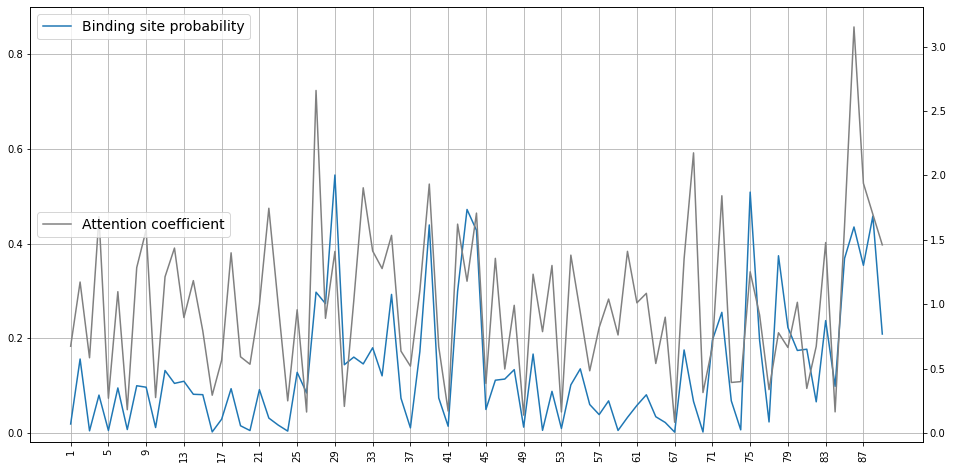

In [4]:

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(vector_binding,label='Binding site probability')

if mode == 'interface':
    ax.set_ylim([-0.02,0.9])
else:
    ax.set_ylim([-0.02,0.52])
ax2 = ax.twinx()
ax2.plot(vector_attention, c='gray',label='Attention coefficient')
ax.set_xticks(np.arange(nresidues)[::4])
ax.set_xticklabels(resnumber[::4], rotation=90)
ax.grid()
ax.legend(fontsize=14,loc='upper left')
ax2.legend(fontsize=14,loc='center left')
plt.show()


In [5]:
if mode == 'interface':
    mini = 0
    maxi = 0.7
else:
    mini = 0
    maxi = 0.35

view = ngl.display(chain[0],dictionary_binding,
            representation = 'cartoon',
            mini=mini,maxi=maxi)
view

NGLWidget()

In [6]:
view = ngl.display(chain[0],dictionary_attention,
            representation = 'cartoon',
            mini=0.5,maxi=2.5)
view

NGLWidget()

In [9]:
modelid = 0
chainid = 'D'
residue = 76

print ('Residue: %s%s, binding: %.3f, attention: %.3f'%(
residue,
sequence[resnumber.index(residue)],
dictionary_binding[(modelid,chainid,residue)],
dictionary_attention[(modelid,chainid,residue)],    
) 
      )


residue_index = resnumber.index(residue)

Residue: 76E, binding: 0.195, attention: 0.917


# Explain model prediction based on atomic filters activity

693 87


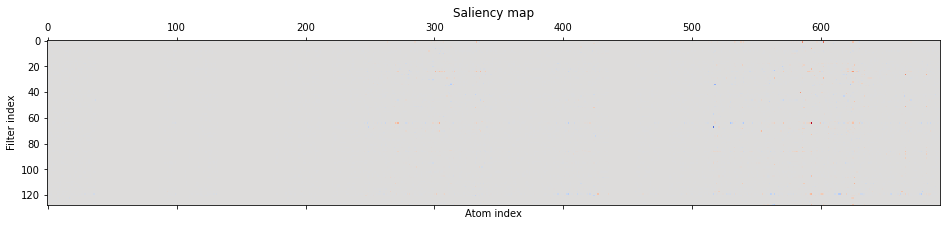

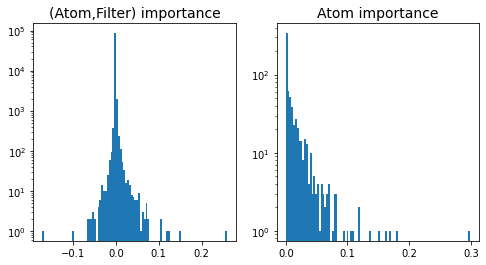

75 NH2 64 0.25846660173831637
76 OE2 1 0.15021078750814354
86 O 26 0.12160452707477898
75 O 1 0.11820768766286682
75 CA 40 0.10785494422112363
80 O 24 0.10462371799592773
66 CA 34 -0.10060152807395895
66 N 67 -0.17137757620199068


In [10]:
saliency,gradient,activation,baseline_activation = get_saliency(model, 
                                                       inputs,residue_index, 
                 filter_specificities,sequence,atomids,layer='SCAN_filter_activity_atom')



plt.matshow(saliency.T, aspect='auto',
            cmap='coolwarm', vmax=0.8 * np.abs(saliency).max(), vmin=- 0.8 * np.abs(saliency).max())
plt.title('Saliency map')
plt.xlabel('Atom index')
plt.ylabel('Filter index')
plt.show()


fig, ax = plt.subplots(ncols=2,figsize=(8,4))

ax[0].hist(saliency.flatten(), bins=100, log=True)
atom_importance = np.sqrt((saliency ** 2).sum(-1))
ax[0].set_title('(Atom,Filter) importance',fontsize=14)
ax[1].hist(atom_importance, bins=100, log=True)
ax[1].set_title('Atom importance',fontsize=14)
plt.show()


explaining_atom_pairs = np.nonzero(np.abs(saliency) >= 0.1)
explanation_values = saliency[explaining_atom_pairs[0], explaining_atom_pairs[1]]

order = np.argsort(explanation_values)[::-1]

explaining_resids = [resnumber[x] for x in inputs[6][explaining_atom_pairs[0], 0]]
atomids_flat = flatten_list(atomids)
explaining_atomids = [protein_chemistry.list_atoms[x] for x in atomids_flat[explaining_atom_pairs[0]]]

nexplanations = len(explaining_resids)

for n in order:
    print(explaining_resids[n], explaining_atomids[n], explaining_atom_pairs[1][n], explanation_values[n])




In [11]:
explaining_residue = 75
explaining_atom = 'NH2'
explaining_filter =64

if renderer is not None: # Clear previous objects
    renderer.close()

atom_positions,atom_types,atom_bonds = show_3d_neighborhoods.get_neighborhood(
        pdb = pdbid[:4],
        model = modelid,
        chain = chainid,
        resnumber = explaining_residue,
        atom = explaining_atom,
        assembly=False,
#         assembly = [(0,'A'),(0,'D')],    
        biounit=biounit,
)


list_objects = show_3d_neighborhoods.show_atoms(atom_positions,atom_types,atom_bonds,render=False,
                                               radius_scale = 0.15)

renderer = show_3d_filters.plot_atomic_filter(filter_specificities,
                                                 explaining_filter,
                                                  y_offset = 0.25,
                                                 sg=sg,
                                                 list_additional_objects=list_objects,
                                                threshold1=0.33);
display(renderer)

Parsing /Users/jerometubiana/PDB/pdb1brs.bioent


Renderer(camera=PerspectiveCamera(position=(8.0, 5.0, 8.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.…

<Figure size 288x576 with 0 Axes>

<Figure size 288x576 with 0 Axes>

<Figure size 288x576 with 0 Axes>

<Figure size 288x576 with 0 Axes>

# Explain model prediction based on amino acid filters activity

In [ ]:
saliency,gradient,activation,baseline_activation = get_saliency(model, 
                                                       inputs,residue_index, 
                 filter_specificities,sequence,atomids,layer='SCAN_filter_activity_aa')



plt.matshow(saliency.T, aspect='auto',
            cmap='coolwarm', vmax=0.8 * np.abs(saliency).max(), vmin=- 0.8 * np.abs(saliency).max())
plt.title('Saliency map')
plt.xlabel('Atom index')
plt.ylabel('Filter index')
plt.show()


fig, ax = plt.subplots(ncols=2,figsize=(8,4))

ax[0].hist(saliency.flatten(), bins=100, log=True)
residue_importance = np.sqrt((saliency ** 2).sum(-1))
ax[0].set_title('(Residue,Filter) importance',fontsize=14)
ax[1].hist(residue_importance, bins=100, log=True)
ax[1].set_title('Residue importance',fontsize=14)
plt.show()


explaining_residue_pairs = np.nonzero(np.abs(saliency) >= 0.1)
explanation_saliencies = saliency[explaining_residue_pairs[0], explaining_residue_pairs[1]]
explanation_values = activation[explaining_residue_pairs[0], explaining_residue_pairs[1]]

order = np.argsort(explanation_saliencies)[::-1]

explaining_resids = [resnumber[x] for x in explaining_residue_pairs[0] ]
explaining_residue = [sequence[x] for x in explaining_residue_pairs[0] ]

nexplanations = len(explaining_resids)

for n in order:
    print('RESID: %s %s Filter: %s, Activity: %.2f, Saliency %.2f ' % (explaining_resids[n], explaining_residue[n], explaining_residue_pairs[1][n], 
          explanation_values[n], explanation_saliencies[n]) )





In [ ]:
explaining_residue = 35
explaining_filter = 111

if renderer is not None: # Clear previous objects
    renderer.close()


aa_positions,aa_types,aa_peptide_bonds = show_3d_neighborhoods.get_neighborhood_aa(
        pdb = pdbid[:4],
        model = modelid,
        chain = chainid,
        resnumber = explaining_residue,
        assembly=False,
        biounit=biounit,
        Kmax=16
)

list_objects = show_3d_neighborhoods.show_aminoacids(aa_positions,aa_types,aa_peptide_bonds,sg=sg,render=False);

renderer = show_3d_filters.plot_aminoacid_filter(filter_specificities,
                                                 explaining_filter,
                                                 sg=sg,
                                                 list_additional_objects=list_objects,
                                                 threshold1=0.33,scale=3.0);
display(renderer)

# Explain model prediction based on sequence/PSSM profile

In [ ]:
# gradient,activation = get_gradient(model, inputs, residue_index, 
#                                    layer = 'attributes_aa'
#                                  )
-
seqnum = sequence_utils.seq2num(sequence)[0]

if use_MSA:
    baseline_activation = np.zeros([1,21])/21
    saliency = (gradient * (activation - baseline_activation ) )
    plt.matshow(activation.T,aspect='auto',cmap='coolwarm'); plt.show()
    
    plt.matshow(saliency.T, aspect='auto',
            cmap='coolwarm', vmax=0.8 * np.abs(saliency).max(), vmin=- 0.8 * np.abs(saliency).max())

    
else:
    baseline_activation = np.array([1] + 19)[np.newaxis]
    saliency = (gradient * (activation - baseline_activation ) ).sum(-1)
    plt.plot(saliency)
    plt.title('Saliency map')
    plt.xlabel('Residue index')
    plt.ylabel('Saliency')
    plt.show()


# fig, ax = plt.subplots(ncols=2,figsize=(8,4))

# ax[0].hist(saliency.flatten(), bins=100, log=True)
# residue_importance = np.sqrt((saliency ** 2).sum(-1))
# ax[0].set_title('(Residue,Filter) importance',fontsize=14)
# ax[1].hist(residue_importance, bins=100, log=True)
# ax[1].set_title('Residue importance',fontsize=14)
# plt.show()


# explaining_residues = np.abs(saliency)>0.2
# explanation_saliencies = saliency[explaining_residues]

# order = np.argsort(explanation_saliencies)[::-1]

# explaining_resids = [resnumber[x] for x in explaining_residue_pairs[0] ]
# explaining_residue = [sequence[x] for x in explaining_residue_pairs[0] ]

# nexplanations = len(explaining_resids)

# for n in order:
#     print('RESID: %s %s Saliency %.2f ' % (explaining_resids[n], explaining_residue[n], explanation_saliencies[n]) )






In [ ]:

aa_positions,aa_types,aa_peptide_bonds = show_3d_neighborhoods.get_neighborhood_aa(
        pdb = pdbid[:4],
        model = modelid,
        chain = chainid,
        resnumber = explaining_residue,
        assembly=False,
        biounit=biounit,
        Kmax=16
)

list_objects = show_3d_neighborhoods.show_aminoacids(aa_positions,aa_types,aa_peptide_bonds,sg=sg,render=False)

renderer = show_3d_filters.plot_aminoacid_filter(filter_specificities,
                                                 explaining_filter,
                                                 sg=sg,
                                                 list_additional_objects=list_objects,
                                                 threshold1=0.33,scale=3.0);
display(renderer)

In [ ]:
def virtual_mutagenesis(model, inputs,residue_index, 
                 filter_specificities,sequence,atomids):
    saliency_atom,gradient_atom,activation_atom,baseline_activation_atom = get_saliency(model, inputs, 
                 residue_index, 
                 filter_specificities,sequence,atomids,layer='all_embedded_attributes_aa')

    saliency_sequence,gradient_sequence,activation_sequence,baseline_activation_sequence = get_saliency(model, inputs, 
                 residue_index, 
                 filter_specificities,sequence,atomids,layer='attributes_aa')
    
    atom_term = (gradient_atom[:,:,np.newaxis] * (baseline_activation_atom[:,:,np.newaxis] - filter_specificities['aggregated_atom_activity']['conditional_median'].T[np.newaxis] ) ).sum(1)
    sequence_term = (gradient_sequence[:,:,np.newaxis] *  (activation_sequence[:,:,np.newaxis] - np.eye(20)[np.newaxis]  ) ).sum(1)
    return atom_term + sequence_term


output = virtual_mutagenesis(model, inputs,residue_index, 
                 filter_specificities,sequence,atomids)


plt.matshow(output.T,vmin=-0.5,vmax=0.5)

In [ ]:
plt.plot(output[:,0]); plt.show()

In [ ]:
order = np.argsort(np.abs(output[:,0]))[::-1]

for u in order[:10]:
    print('%s%s: contribution %.2f'%(resnumber[u],sequence[u], output[u,0]) )